<a href="https://colab.research.google.com/github/AnuragRaut08/CreditSaathi/blob/main/CreditSaathi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training data shape: (1296675, 23)
Test data shape: (555719, 23)
   Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   
3           3   2019-01-01 00:01:16  3534093764340240   
4           4   2019-01-01 00:03:06   375534208663984   

                             merchant       category     amt      first  \
0          fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer   
1     fraud_Heller, Gutmann and Zieme    grocery_pos  107.23  Stephanie   
2                fraud_Lind-Buckridge  entertainment  220.11     Edward   
3  fraud_Kutch, Hermiston and Farrell  gas_transport   45.00     Jeremy   
4                 fraud_Keeling-Crist       misc_pos   41.96      Tyler   

      last gender                        street  ...      lat      long  \
0    Banks      F                561 Perry Cove  ...  36.0788  -81

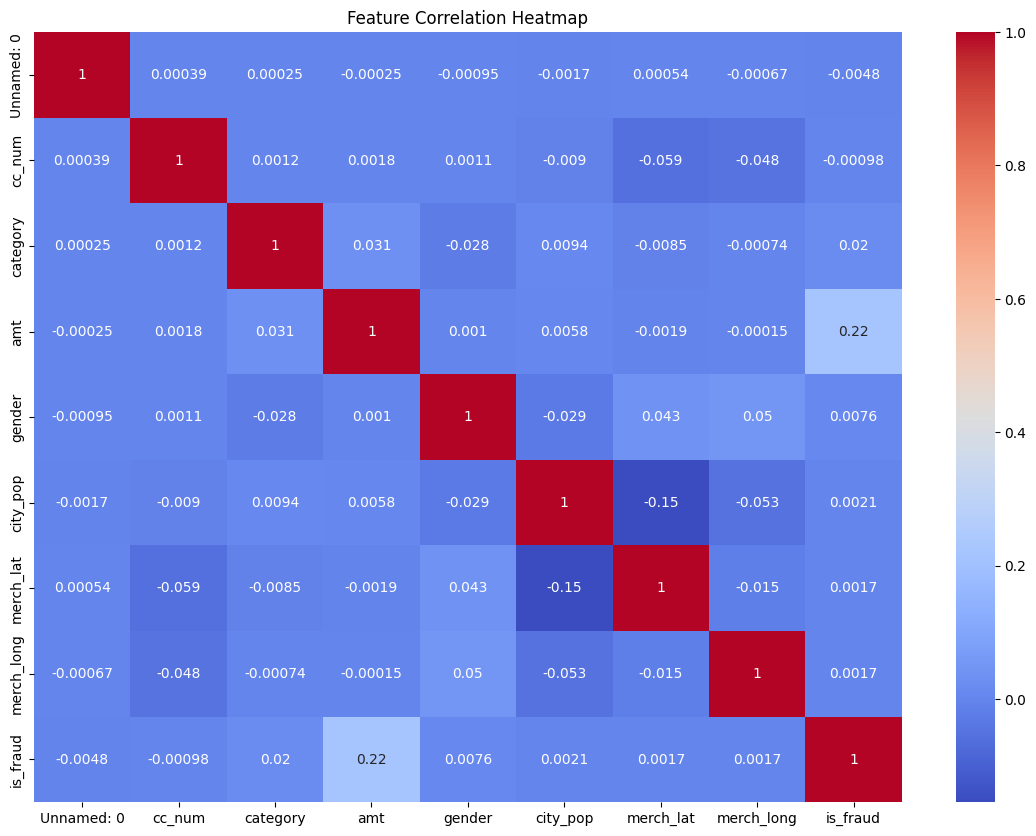

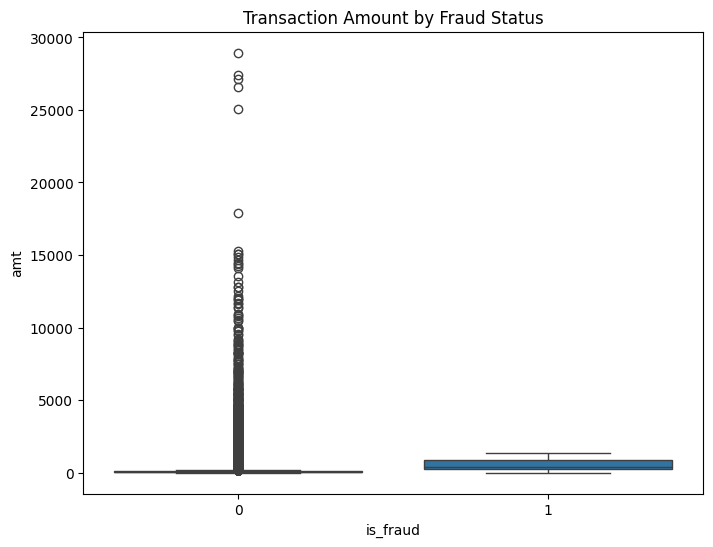

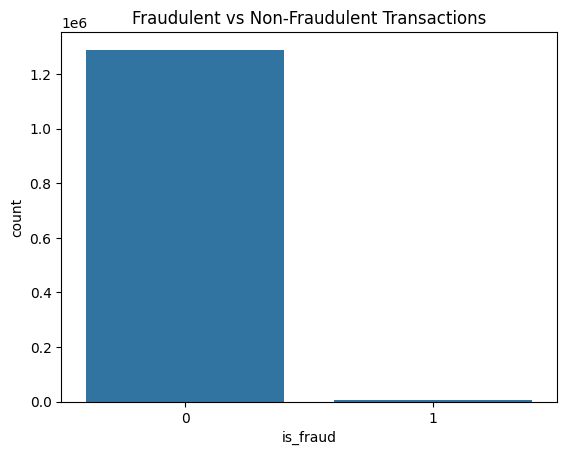

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:39:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve

# 2. Load Datasets
train_df = pd.read_csv('/content/fraudTrain.csv')
test_df = pd.read_csv('/content/fraudTest.csv')

print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)

# 3. Data Exploration
print(train_df.head())
print(train_df.info())
print(train_df.describe())

# 4. Data Cleaning
# Drop useless columns like 'Unnamed', 'trans_num' (transaction number), etc.
cols_to_drop = ['trans_num', 'first', 'last', 'dob', 'unix_time', 'street', 'city', 'state', 'zip', 'lat', 'long', 'job', 'merchant']
train_df = train_df.drop(columns=cols_to_drop)
test_df = test_df.drop(columns=cols_to_drop)

# Handle categorical variables
cat_cols = ['category', 'gender']
le = LabelEncoder()
for col in cat_cols:
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.transform(test_df[col])

# 5. Visualizations
# Correlation Heatmap
# Only take numeric columns for correlation
numeric_cols = train_df.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(14,10))
sns.heatmap(train_df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()


# Fraud vs Legit Transaction Amounts
plt.figure(figsize=(8,6))
sns.boxplot(x='is_fraud', y='amt', data=train_df)
plt.title('Transaction Amount by Fraud Status')
plt.show()

# Count of Fraudulent vs Non-Fraudulent Transactions
sns.countplot(x='is_fraud', data=train_df)
plt.title('Fraudulent vs Non-Fraudulent Transactions')
plt.show()

# 6. Feature Engineering
X_train = train_df.drop('is_fraud', axis=1)
y_train = train_df['is_fraud']

X_test = test_df.drop('is_fraud', axis=1)
y_test = test_df['is_fraud']

# Drop the 'trans_date_trans_time' column
X_train = X_train.drop(columns=['trans_date_trans_time'])
X_test = X_test.drop(columns=['trans_date_trans_time'])

# Now scaling will work
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 7. Model Training
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf_model.fit(X_train_scaled, y_train)

# XGBoost (Optional Second Model)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# 8. Model Evaluation (Random Forest)
rf_preds = rf_model.predict(X_test_scaled)
print("Random Forest Classification Report:\n", classification_report(y_test, rf_preds))

# Confusion Matrix
cm = confusion_matrix(y_test, rf_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Random Forest)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC-AUC
rf_probs = rf_model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, rf_probs)
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc_score(y_test, rf_probs):.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, rf_probs)
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# 9. Feature Importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train.columns

plt.figure(figsize=(12,6))
sns.barplot(x=importances[indices][:10], y=features[indices][:10])
plt.title('Top 10 Feature Importances (Random Forest)')
plt.show()

# 10. Analyzing Misclassifications
misclassified = X_test[(rf_preds != y_test)]
print("Some examples of misclassified transactions:")
print(misclassified.head())

# --- END ---

